<a href="https://colab.research.google.com/github/wenfeng7k/pytorch_models/blob/main/multi_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


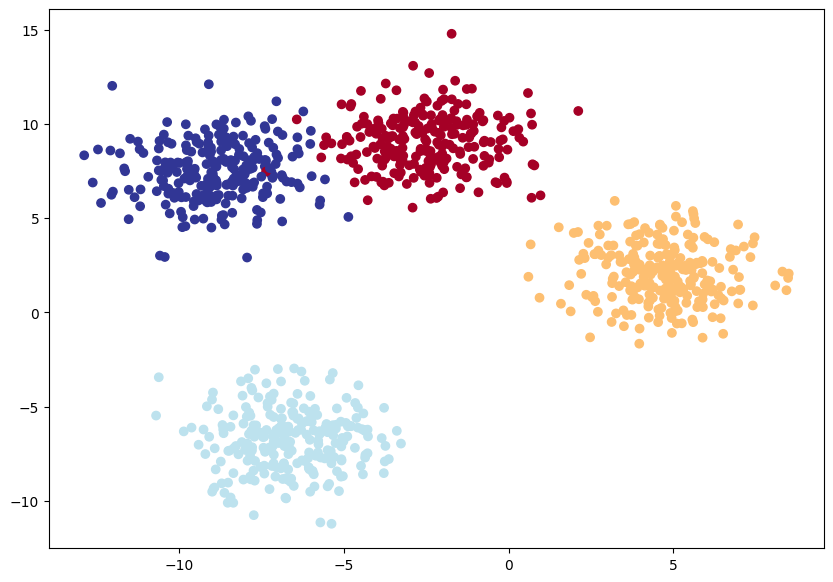

In [ ]:
# import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

#hyperparameters
NUM_CLASSES=4
NUM_FEATURES=2
RANDOM_SEED = 42

#Create multi-class data
X_blob,y_blob = make_blobs(n_samples=1000,
                           n_features=NUM_FEATURES,
                           centers=NUM_CLASSES,
                           cluster_std=1.5,
                           random_state=RANDOM_SEED
                           )

# turn data into tensor
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5],y_blob[:5])

#split into train and test sets
X_blob_train,X_blob_test,y_blob_train,y_blob_test = train_test_split(X_blob,
                                                                     y_blob,
                                                                     test_size=0.2,
                                                                     random_state = RANDOM_SEED)
# Plot data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0],X_blob[:,1],c=y_blob,cmap=plt.cm.RdYlBu);

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
from torch import nn
#Build model
class BlobModel(nn.Module):
  def __init__(self,input_features,output_features,hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )
  def forward(self, x):
    return self.linear_layer_stack(x)
model_0=BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model_0

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [ ]:
#Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_0.parameters(),
                           lr=0.1)

In [ ]:
# Perform a single forward pass on the data
model_0(X_blob_train.to(device))[:5]

tensor([[-0.0172,  1.2595, -0.0645, -0.7938],
        [-0.8133,  1.4799,  0.1955, -0.6487],
        [ 0.3092, -1.5211,  0.1387,  1.5626],
        [ 0.0760, -0.6928,  0.1269,  0.9193],
        [-0.6729,  1.1083,  0.1880, -0.3754]], grad_fn=<SliceBackward0>)

In [ ]:
model_0(X_blob_train.to(device))[0].shape,NUM_CLASSES

(torch.Size([4]), 4)

In [ ]:
# Make prediction logits with model
y_logits = model_0(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.1212,  1.3894, -0.0422, -0.8656],
        [-0.8508,  0.6834,  0.3007,  0.0827],
        [ 0.3191, -1.1778,  0.0956,  1.2501],
        [ 0.0820,  0.8597, -0.0540, -0.4775],
        [-0.7525,  1.7690,  0.1405, -0.9344]], grad_fn=<SliceBackward0>)
tensor([[0.1411, 0.6392, 0.1527, 0.0670],
        [0.0882, 0.4088, 0.2788, 0.2242],
        [0.2193, 0.0491, 0.1754, 0.5563],
        [0.2164, 0.4710, 0.1889, 0.1237],
        [0.0598, 0.7443, 0.1461, 0.0499]], grad_fn=<SliceBackward0>)


In [ ]:
# Sum the first sample output of the softmax activation function
torch.sum(y_pred_probs[0])

tensor(1.0000, grad_fn=<SumBackward0>)

In [ ]:
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.1411, 0.6392, 0.1527, 0.0670], grad_fn=<SelectBackward0>)
tensor(1)


In [ ]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [ ]:
#Fit the model
torch.manual_seed(42)
#Set number of epochs
epochs = 100

#put data to target device
X_blob_train ,y_blob_train = X_blob_train.to(device),y_blob_train.to(device)
X_blob_test,y_blob_test = X_blob_test.to(device),y_blob_test.to(device)

for epoch in range(epochs):
  ###training
  model_0.train()

  #1.Forward pass
  y_logits = model_0(X_blob_train)# model outputs raw logits
  y_pred = torch.softmax(y_logits,dim=1).argmax(dim = 1)

  #2.Calculate loss and accuracy
  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,
                    y_pred = y_pred)
  # optimizer zero grad
  optimizer.zero_grad()

  #4.loss backwards
  loss.backward()

  #5. optimizer step
  optimizer.step()

  ###testing
  model_0.eval()
  with torch.inference_mode():
    #1.forward pass
    test_logits = model_0(X_blob_test)
    test_pred = torch.softmax(test_logits,dim=1).argmax(dim=1)
    #Calculate test loss and accuracy
    test_loss =loss_fn(test_logits,y_blob_test)
    test_acc=accuracy_fn(y_true=y_blob_test,
                         y_pred = test_pred)

    #Printing
    if epoch %10==0:
      print(f"Epoch: {epoch}  Loss: {loss:.5f},Acc:{acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc:{test_acc:.2f}%"),

Epoch: 0  Loss: 1.60432,Acc:28.50% | Test Loss: 0.70128, Test Acc:76.00%
Epoch: 10  Loss: 0.15381,Acc:99.12% | Test Loss: 0.13930, Test Acc:99.50%
Epoch: 20  Loss: 0.08566,Acc:99.12% | Test Loss: 0.07735, Test Acc:99.50%
Epoch: 30  Loss: 0.06235,Acc:99.12% | Test Loss: 0.05464, Test Acc:99.50%
Epoch: 40  Loss: 0.05106,Acc:99.12% | Test Loss: 0.04328, Test Acc:99.50%
Epoch: 50  Loss: 0.04454,Acc:99.12% | Test Loss: 0.03656, Test Acc:99.50%
Epoch: 60  Loss: 0.04035,Acc:99.12% | Test Loss: 0.03216, Test Acc:99.50%
Epoch: 70  Loss: 0.03745,Acc:99.12% | Test Loss: 0.02907, Test Acc:99.50%
Epoch: 80  Loss: 0.03534,Acc:99.12% | Test Loss: 0.02679, Test Acc:99.50%
Epoch: 90  Loss: 0.03374,Acc:99.12% | Test Loss: 0.02503, Test Acc:99.50%


In [ ]:
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_blob_test)
y_logits[:10]

tensor([[  5.9473,  11.1707, -11.3997,  -7.3889],
        [  1.4741, -12.9244,  -0.3042,   7.1021],
        [ -9.6333, -13.2643,  17.9351,   9.5452],
        [  2.7576,   8.4231,  -5.7470,  -5.1933],
        [  8.1252,   3.2167, -13.7206,  -3.3461],
        [  1.3831, -16.1097,   0.3433,   8.9163],
        [ -9.2989,  -9.8417,  16.8519,   7.5478],
        [  6.1750,  -1.0300,  -9.8628,  -0.5565],
        [-10.8481, -18.9022,  20.8066,  12.9699],
        [  6.7595,   0.5340, -11.0647,  -1.5568]])

In [ ]:
#Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits,dim=1)
#Turn prediciton probabilities into prediciton labels
y_preds = y_pred_probs.argmax(dim=1)
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Test accuracy: 99.5%


In [ ]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)
from helper_functions import plot_predictions, plot_decision_boundary



helper_functions.py already exists, skipping download


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

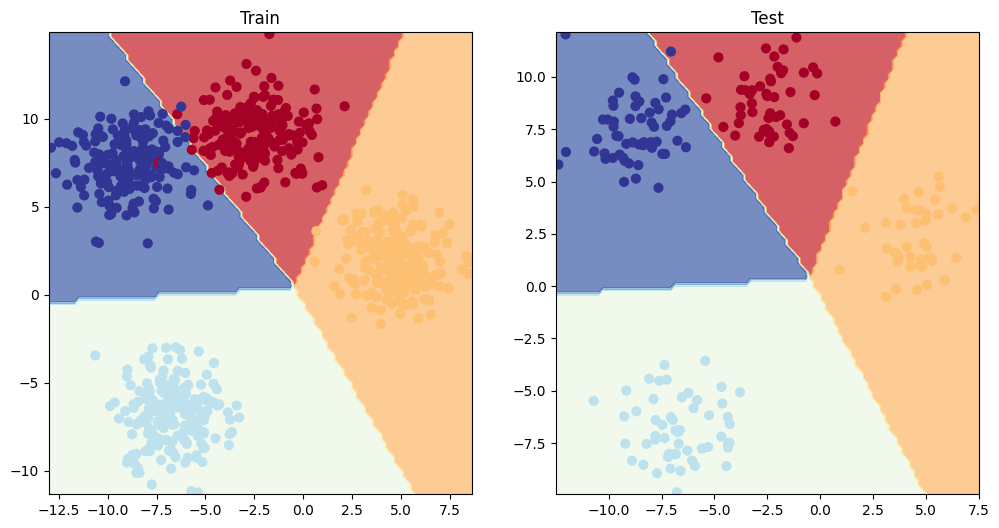

In [ ]:
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_blob_train,y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,X_blob_test, y_blob_test)


In [ ]:
try:
  from torchmetrics import Accuracy
except:
  !pip install torchmetrics==0.9.3
torchmetrics_accuracy = Accuracy(task="multicalss",num_classes=4).to(device)

torchmetrics_accuracy(y_preds,y_blob_test)

tensor(0.9950)